In [ ]:
pip install office31


In [ ]:
from office31 import office31

train, val, test = office31(
    source_name = "webcam",
    target_name = "dslr",
    seed=1,
    same_to_diff_class_ratio=3,
    image_resize=(240, 240),
    group_in_out=True, # groups data: ((img_s, img_t), (lbl_s, _lbl_t))
    framework_conversion="tensorflow",
    office_path = '/content/Office31', #automatically downloads to "~/data"
)

In [ ]:
import numpy as np
import pickle
import torch
from torch.utils import data                                #to run an ierable over a dataset
from torchvision import datasets, transforms                #for downloading datasets and transforms


def get_dataset_mean_and_std(directory):          
    dataset = datasets.ImageFolder(                          #datasets.ImageFolder: A generic dataloader where 
        directory,                                           #images are arranged by class and subfolders
        transform=transforms.Compose([                       #transform the incoming images to tensors
            transforms.ToTensor()
        ])
    )

    data_loader = data.DataLoader(dataset)                   #data.DataLoader(): makes an dataset into an iterable     

    mean = [0, 0, 0]                                         
    std = [0, 0, 0]
    for channel in range(3):                                  #for 4 channels
        _mean = 0
        _std = 0
        for _, (xs, _) in enumerate(data_loader):             #enumerate makes it (0,num1), (1,num2), (2,num3)
            img = xs[0][channel].numpy()                      #here EACH channel value is being converted to numpy
            _mean += img.mean()                               #each channel is taken and thier values are added together
                                                              #and means are found for each image which is then taken to find
                                                              #the total mean from the average mean of all the images.
            _std += img.std()                                 #thier standard deviation are found and added together
                                                              #this is used to get the mean and std of each channel 
        mean[channel] = _mean/len(dataset)                    #to normalise it. So we will get the mean of all the Channel 1 and Channel 2 and Channel 3
        std[channel] = _std/len(dataset)

    return mean, std


def save(obj, path):                                         #Pickle is a python library to convert a object to a set of bytes
    with open(path, 'wb') as f:                              #which is written to a file
        pickle.dump(obj, f)                               
        print('[INFO] Object saved to {}'.format(path))


def save_net(model, path):                                   
    torch.save(model.state_dict(), path)                     #Stores the parameters for the layers with the learnable parameters
    print('[INFO] Checkpoint saved to {}'.format(path))      


def load_net(model, path):                                   
    model.load_state_dict(torch.load(path))                  #used with Pickle to unpickle and load from the saved .state_dict()  
    print('[INFO] Checkpoint {} loaded'.format(path))

get_train_test_loader() is for external data sources, so that we can split any  incoming new dataset into train and test. Thats why there is a separate mean and std finding part for it and this is also why they using the above code


In [ ]:
def get_train_test_loader(directory, batch_size, testing_size=0.1, img_size=None):
    mean, std = utils.get_dataset_mean_and_std(directory)                           #Gets the mean and standard dev from the whole
    # print(mean, std)                                                              #dataset
    
    transform = [                                                                   
        transforms.ToTensor(),                                                      #sets up the transformations to be effected
        transforms.Normalize(mean, std)                                          
    ]

    if img_size is not None:
        transform.insert(0, transforms.Scale(img_size))                              #to get it into the image size we want

    dataset = datasets.ImageFolder(                                                  #Generic Dataloader to load the images
        directory,                                                                   #where the image is stored in class and sub-classes
        transform=transforms.Compose(transform)                                      #and the transformation are run on each images
    )

    num_data = len(dataset)                                                          #finding the num of images
    indices = list(range(num_data))                                                  #getting the number of data in a list form
    split = int(np.floor(testing_size * num_data))                                   #splitting size on testing and training size

    # Shuffle
    np.random.shuffle(indices)                                                       #shuffling the numbers

    train_idx, test_idx = indices[split:], indices[:split]                           #splitting based on the test size the shuffled data

    train_sampler = data.sampler.SubsetRandomSampler(train_idx)                      #taking or sammples elements randomly
    test_sampler = data.sampler.SubsetRandomSampler(test_idx)                        #from a given list of indcies without replacement
                                                                                     #So we getting a sample from the train and the test
    train_loader = data.DataLoader(                                        
        dataset,
                                                                                    #Datalaoder()-makes the dataset to an iterable
        batch_size=batch_size,                                                      #we can set the batch-size and the sampler
        sampler=train_sampler,                                                      #This is a Map-Style Dataset: such a dataset, when accessed with dataset[idx], 
        drop_last=True                                                              #could read the idx-th image and its corresponding label from a folder on the disk.
    )                                                                               #Automatic Batching: corresponds to fetching a minibatch of data 
                                                                                    #and collating them into batched samples, i.e., containing Tensors 
    test_loader = data.DataLoader(                                                  #with one dimension being the batch dimension (usually the first).
        dataset,                                                                    #The batch_size and drop_last arguments essentially are used to construct a batch_sampler from sampler.
        
        batch_size=batch_size,                                                      #So essentially this creates a random sample of images from from both the domains 
        sampler=test_sampler,                                                       #which is why each epoch takes mutltiple runs. So each sample must be taken out of the batches
        drop_last=True                                                              #and each sample from each batch is run through both the networks. So how is the same Class  being pass aross?
    )

    return train_loader, test_loader                                               


In [ ]:
# For Office31 datasets data_loader
def get_office31_dataloader(case, batch_size):                                                 #Loading the Office31 dataloader
    print('[INFO] Loading datasets: {}'.format(case))
    datas = {
        'amazon': '/content/Office31/amazon/images/',                                          #Location of the original files
        'dslr': '/content/Office31/dslr/images/',
        'webcam': '/content/Office31/webcam/images/'
    }
    means = {
        'amazon': [0.79235075407833078, 0.78620633471295642, 0.78417965306916637],            #hardcoded values of mean, std deviation and imagenet?? Why imagenet? Why no mean for Dslr?
        'webcam': [0.61197983011509638, 0.61876474000372972, 0.61729662103473015],            #Becuase to reduce the computational time 
        'dslr': [],
        'imagenet': [0.485, 0.456, 0.406]
    }
    stds = {
        'amazon': [0.27691643643313618, 0.28152348841965347, 0.28287296762830788],
        'webcam': [0.22763857108616978, 0.23339382150450594, 0.23722725519031848],
        'dslr': [],
        'imagenet': [0.229, 0.224, 0.225]
    }

    img_size = (227, 227)                                                                 #outgoing image size

    transform = [                                                                        #transformations we need to effect scaling, convert to tensor,Normalise based on Imagenet values??? Why? 
        transforms.Resize(img_size),               #Resize                                         #becuase the Alex Net is Pretrained on the ImageNet we are shifting the images to the mean and STD of the
        transforms.ToTensor(),                                                           #ImageNet values.
        transforms.Normalize(means['imagenet'], stds['imagenet']),                                     
    ]

    data_loader = data.DataLoader(                                                      #iterable dataset creation and then we normalise the incoming values based on ImageNet means??
        dataset=datasets.ImageFolder(                                                   
            datas[case],                                                                
            transform=transforms.Compose(transform)
        ),                                                                              #we set the batch size so that input is taken in batchs and resampled from it. But we dont 
                                                                                        #dont know how the same class is taken
        batch_size=batch_size,
        shuffle=True,                                               
        drop_last=True
    )

    return data_loader

In [ ]:
import torch
def CORAL(source, target):                                                    
    d = source.data.shape[1]
    sam_t= target.data.shape[0]
    sam_s= source.data.shape[0]                                                  #dimension 31

     #source covariance
    #xm = torch.mean(source, 0, keepdim=True) - source                     #returns the mean value of each column [0-column,1-row]      
    #xc = xm.t() @ xm

     #target covariance
    #xmt = torch.mean(target, 0, keepdim=True) - target
    #xct = xmt.t() @ xmt

    #frobenius norm between source and target
    #loss = torch.mean(torch.mul((xc - xct), (xc - xct)))                  #1/n*(square(xc-xct))
    #loss = loss/(4*d*d)         

    #loss function according to Paper

    #source covariance  
    xs0= torch.ones(sam_s).to('cuda') 
    xs1= torch.reshape(xs0,[1,sam_s])
    xs2= torch.matmul(xs1,source)

    xs3= torch.matmul(xs2.t(),xs2)
    xs4= xs3/5
    xs5= torch.matmul(source.t(),source)
    xs6=xs5 - xs4
    xsc=1/4*(xs6)

    #target covariance
    xt0= torch.ones(sam_t).to('cuda') 
    xt1= torch.reshape(xt0,[1,sam_t])
    xt2= torch.matmul(xt1,target)

    xt3= torch.matmul(xt2.t(),xt2)
    xt4= xt3/5
    xt5= torch.matmul(target.t(),target)
    xt6=xt5 - xt4
    xtc=1/4*(xt6)

    #frobenius norm between source and target
    loss = torch.mean(torch.mul((xsc - xtc), (xsc - xtc)))                  #1/n*(square(xc-xct))
    loss = loss/(4*d*d)
    

    
    
    return loss*10

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function, Variable                                 #Every operation performed on tensor creates a new function that performs the operation
from math import sqrt                                                         #and records that it happended. It defins the formula for differnetiating ops
                                                                              #variable has to be replaced by- requires grad(true)



class DeepCORAL(nn.Module):
    def __init__(self, num_classes=1000):
        super(DeepCORAL, self).__init__()
        self.sharedNet = AlexNet()
        self.fc = nn.Linear(4096, num_classes)

        # initialize according to CORAL paper experiment (This is a range between values as mentioned in the DEEPCoral paper)
        self.fc.weight.data.normal_(0, 0.005)

    def forward(self, source, target):
        source = self.sharedNet(source)
        source = self.fc(source)

        target = self.sharedNet(target)
        target = self.fc(target)
        return source, target


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),   # Except for the last two layers we need to set the gradients as false for 
            nn.ReLU(inplace=True),                                    #every other loss
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [ ]:
from __future__ import division
import argparse
import torch
from torch.utils import model_zoo
from torch.autograd import Variable

#import models
#import utils
#from data_loader import get_train_test_loader, get_office31_dataloader


CUDA = True if torch.cuda.is_available() else False
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
BATCH_SIZE = [200, 56]
EPOCHS = 20


source_loader = get_office31_dataloader(case='amazon', batch_size=BATCH_SIZE[0])
target_loader = get_office31_dataloader(case='webcam', batch_size=BATCH_SIZE[1])


def train(model, optimizer, epoch, _lambda):
    result = []

    # Expected size : xs -> (batch_size, 3, 300, 300), ys -> (batch_size)
    source, target = list(enumerate(source_loader)), list(enumerate(target_loader))
    train_steps = min(len(source), len(target))

    for batch_idx in range(train_steps):
        _, (source_data, source_label) = source[batch_idx]
        _, (target_data, _) = target[batch_idx]
        #if CUDA:
           # source_data = source_data.cuda()
           # source_label = source_label.cuda()
           # target_data = target_data.cuda()

        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)

        optimizer.zero_grad()  #clears all the gradients from the last step
        out1, out2 = model(source_data, target_data)
        #print(out1.shape,out2.shape)

        classification_loss = torch.nn.functional.cross_entropy(out1, source_label)
        coral_loss = CORAL(out1, out2)

        sum_loss = _lambda*coral_loss + classification_loss # this is where we need to add our new loss functions
        sum_loss.backward()  #finds the new gradients

        optimizer.step()  #updates using the new gradients

        result.append({
            'epoch': epoch,
            'step': batch_idx + 1,
            'total_steps': train_steps,
            'lambda': _lambda,
            'coral_loss': coral_loss,
            'classification_loss': classification_loss,
            'total_loss': sum_loss.data
        })

        print('Train Epoch: {:2d} [{:2d}/{:2d}]\t'
              'Lambda: {:.4f}, Class: {:.6f}, CORAL: {:.6f}, Total_Loss: {:.6f}'.format(
                  epoch,
                  batch_idx + 1,
                  train_steps,
                  _lambda,
                  classification_loss,
                  coral_loss,
                  sum_loss
              ))

    return result


def test(model, dataset_loader, e):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataset_loader:
       # if CUDA:
       #     data, target = data.cuda(), target.cuda()

        data=Variable(data, requires_grad=False)
        target= Variable(target)
        out, _ = model(data, data)

        # sum up batch loss
        test_loss += torch.nn.functional.cross_entropy(out, target, reduction='sum').data

        # get the index of the max log-probability
        pred = out.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(dataset_loader.dataset)

    return {
        'epoch': e,
        'average_loss': test_loss,
        'correct': correct,
        'total': len(dataset_loader.dataset),
        'accuracy': 100. * correct / len(dataset_loader.dataset)
    }


# load AlexNet pre-trained model
def load_pretrained(model):
    url = 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'
    pretrained_dict = model_zoo.load_url(url)
    model_dict = model.state_dict()

    # filter out unmatch dict and delete last fc bias, weight
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # del pretrained_dict['classifier.6.bias']
    # del pretrained_dict['classifier.6.weight']

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)


if __name__ == '__main__':
    
    model = DeepCORAL(31)

    # support different learning rate according to CORAL paper
    # i.e. 10 times learning rate for the last two fc layers.
    optimizer = torch.optim.SGD([
        {'params': model.sharedNet.parameters()},
        {'params': model.fc.parameters(), 'lr': 10*LEARNING_RATE},
    ], lr=LEARNING_RATE, momentum=MOMENTUM)

  #  if CUDA:
  #      model = model.cuda()

    load_pretrained(model.sharedNet)

    training_statistic = []
    testing_s_statistic = []
    testing_t_statistic = []

    for e in range(0, EPOCHS):
        _lambda = (e+1)/EPOCHS
        # _lambda = 0.0
        res = train(model, optimizer, e+1, _lambda)
        print('###EPOCH {}: Class: {:.6f}, CORAL: {:.6f}, Total_Loss: {:.6f}'.format(
            e+1,
            sum(row['classification_loss'] / row['total_steps'] for row in res),
            sum(row['coral_loss'] / row['total_steps'] for row in res),
            sum(row['total_loss'] / row['total_steps'] for row in res),
        ))

        training_statistic.append(res)

        test_source = test(model, source_loader, e)
        test_target = test(model, target_loader, e)
        testing_s_statistic.append(test_source)
        testing_t_statistic.append(test_target)

        print('###Test Source: Epoch: {}, avg_loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
            e+1,
            test_source['average_loss'],
            test_source['correct'],
            test_source['total'],
            test_source['accuracy'],
        ))
        print('###Test Target: Epoch: {}, avg_loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
            e+1,
            test_target['average_loss'],
            test_target['correct'],
            test_target['total'],
            test_target['accuracy'],
        ))

    save(training_statistic, 'training_statistic.pkl')
    save(testing_s_statistic, 'testing_s_statistic.pkl')
    save(testing_t_statistic, 'testing_t_statistic.pkl')
    save_net(model, 'checkpoint.tar')

[INFO] Loading datasets: amazon
[INFO] Loading datasets: webcam


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
#Changes to code 
#1. made it Scale to Resize
#2. made it work with "req_grad=True"

Paper Formula


In [ ]:
import torch
D_S=torch.tensor([[90,60,90],[90,90,30],[60,60,60],[60,60,90],[30,30,30]])

In [ ]:
D_S

tensor([[90, 60, 90],
        [90, 90, 30],
        [60, 60, 60],
        [60, 60, 90],
        [30, 30, 30]])

In [ ]:
D_S.shape

torch.Size([5, 3])

In [ ]:
tr1=torch.matmul(D_S.t(),D_S)

In [ ]:
tr1

tensor([[24300, 21600, 20700],
        [21600, 19800, 18000],
        [20700, 18000, 21600]])

In [ ]:
tr2=torch.ones(5)
tr2.shape

torch.Size([5])

In [ ]:
tr3=torch.reshape(tr2,[1,5])

In [ ]:
tr3= tr3.type(torch.LongTensor)
tr3.shape

torch.Size([1, 5])

In [ ]:
tr4=torch.matmul(tr3, D_S)

In [ ]:
tr4

tensor([[330, 300, 300]])

In [ ]:
tr5=torch.matmul(tr4.t(),tr4)

In [ ]:
tr5

tensor([[108900,  99000,  99000],
        [ 99000,  90000,  90000],
        [ 99000,  90000,  90000]])

In [ ]:
tr6=tr5/5

In [ ]:
tr6

tensor([[21780., 19800., 19800.],
        [19800., 18000., 18000.],
        [19800., 18000., 18000.]])

In [ ]:
CR2=1/4*(tr1 - tr6)

In [ ]:
CR2

tensor([[630., 450., 225.],
        [450., 450.,   0.],
        [225.,   0., 900.]])

Covariance

In [ ]:
import numpy as np

arr = np.array([[90,60,90],[90,90,30],[60,60,60],[60,60,90],[30,30,30]])

print(arr)

[[90 60 90]
 [90 90 30]
 [60 60 60]
 [60 60 90]
 [30 30 30]]


In [ ]:
arr1=np.transpose(arr)
print(arr1)
print(np.cov(arr))
print(np.cov(arr1))

[[90 90 60 60 30]
 [60 90 60 60 30]
 [90 30 60 90 30]]
[[ 300. -300.    0.  150.    0.]
 [-300. 1200.    0. -600.    0.]
 [   0.    0.    0.    0.    0.]
 [ 150. -600.    0.  300.    0.]
 [   0.    0.    0.    0.    0.]]
[[630. 450. 225.]
 [450. 450.   0.]
 [225.   0. 900.]]


Variance-Covariance Equation

In [ ]:
arr

array([[90, 60, 90],
       [90, 90, 30],
       [60, 60, 60],
       [60, 60, 90],
       [30, 30, 30]])

In [ ]:
e1=np.ones((5,5))
e1.shape
e1

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [ ]:
a=arr-e1 @ arr * (1/5)
a

array([[ 24.,   0.,  30.],
       [ 24.,  30., -30.],
       [ -6.,   0.,   0.],
       [ -6.,   0.,  30.],
       [-36., -30., -30.]])

In [ ]:
a_t=np.transpose(a)
a_t

array([[ 24.,  24.,  -6.,  -6., -36.],
       [  0.,  30.,   0.,   0., -30.],
       [ 30., -30.,   0.,  30., -30.]])

In [ ]:
V=a_t @ a / 5

In [ ]:
V

array([[504., 360., 180.],
       [360., 360.,   0.],
       [180.,   0., 720.]])

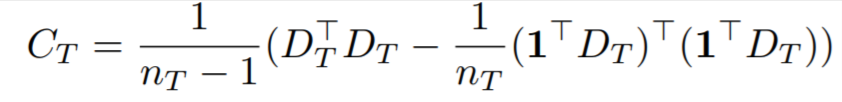

May be it was a way of getting the relation between the dimensions